<a href="https://colab.research.google.com/github/4graf/Data_Processing/blob/main/PySpark%20processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка к работе с PySpark

> Установка библиотек для работы с PySpark в Google Colab (актуальную версию Spark можно посмотреть на официальном сайте https://spark.apache.org/downloads.html):

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz

!pip install -q findspark

--2022-12-29 20:38:36--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299350810 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.1-bin-hadoop3.tgz’

spark-3.3.1-bin-had 100%[===================>] 285.48M   247MB/s    in 1.2s    

2022-12-29 20:38:38 (247 MB/s) - ‘spark-3.3.1-bin-hadoop3.tgz’ saved [299350810/299350810]



> Указываем пути на установленные модули:

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

> Инициализация сессии PySpark:

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# **Подключение необходимых для работы библиотек:**

In [ ]:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F

# Работа с PySpark

Загрузим исходные данные из *.csv* файла (https://docs.google.com/spreadsheets/d/1SK5LL-0HVERsrqAl-wXk8kH2yz2raO8tO_whfhxIBr4/edit#gid=447851735):

In [ ]:
df = spark.read.csv("Арсений Набатов - daily_weather.csv",
               sep=',', header=True, inferSchema=True)

Описание исходных данных:

In [ ]:
print(f'Столбцов - {len(df.columns)}')
print(f'Строк - {df.count()}')
df.printSchema()

df_descript = df.describe().toPandas().T
df_descript.rename(columns=dict(zip(df_descript.columns, df_descript.iloc[0])), inplace=True)
df_descript.drop(df_descript.index[0:2], inplace=True)
df_descript = df_descript.apply(pd.to_numeric)
df_descript

Столбцов - 11
Строк - 1095
root
 |-- number: integer (nullable = true)
 |-- air_pressure_9am: double (nullable = true)
 |-- air_temp_9am: double (nullable = true)
 |-- avg_wind_direction_9am: double (nullable = true)
 |-- avg_wind_speed_9am: double (nullable = true)
 |-- max_wind_direction_9am: double (nullable = true)
 |-- max_wind_speed_9am: double (nullable = true)
 |-- rain_accumulation_9am: double (nullable = true)
 |-- rain_duration_9am: double (nullable = true)
 |-- relative_humidity_9am: double (nullable = true)
 |-- relative_humidity_3pm: double (nullable = true)



,count,mean,stddev,min,max
air_pressure_9am,1092,918.882551,3.184161,907.990000,929.320000
air_temp_9am,1090,64.933001,11.175514,36.752000,98.906000
avg_wind_direction_9am,1091,142.235511,69.137859,15.500000,343.400000
avg_wind_speed_9am,1092,5.508284,4.552813,0.693451,23.554978
max_wind_direction_9am,1092,148.953518,67.238013,28.900000,312.200000
max_wind_speed_9am,1091,7.019514,5.598209,1.185578,29.840780
rain_accumulation_9am,1089,0.203079,1.593952,0.000000,24.020000
rain_duration_9am,1092,294.108052,1598.078779,0.000000,17704.000000
relative_humidity_9am,1095,34.241402,25.472067,6.090000,92.620000
relative_humidity_3pm,1095,35.344727,22.524079,5.300000,92.250000


Количества элементов в столбцах различно, что означает наличие **пустых значений**. Количество **пустых значений**:

In [ ]:
print((df.count() - df_descript['count']))
# df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

air_pressure_9am          3
air_temp_9am              5
avg_wind_direction_9am    4
avg_wind_speed_9am        3
max_wind_direction_9am    3
max_wind_speed_9am        4
rain_accumulation_9am     6
rain_duration_9am         3
relative_humidity_9am     0
relative_humidity_3pm     0
Name: count, dtype: int64


Рассмотрим 3 способа заполнения пустых значений: **среднее, медиана и мода**. Сравним их на примере столбца *air_temp_9am*:

In [ ]:
air_temp_9am = {}


# Среднее значение
df_mean = df.select(['air_temp_9am'])
mean_value = df_mean.select(F.mean(F.col('air_temp_9am'))).\
                            first()[0]
print(f'mean_value = {mean_value}')
df_mean = df_mean.fillna(mean_value)

air_temp_9am['mean'] = df_mean


# Медианное значение
df_median = df.select(['air_temp_9am'])
median_value = df_median.agg(F.percentile_approx('air_temp_9am', 0.5)).\
                            first()[0]
print(f'median_value = {median_value}')
df_median = df_median.fillna(median_value)

air_temp_9am['median'] = df_median


# Наиболее частое значение
df_mode = df.select(['air_temp_9am'])
mode_value = df_mode.filter(F.col('air_temp_9am').isNotNull()).\
            groupBy('air_temp_9am').count().orderBy('count', ascending=False).\
            first()[0]

print(f'mode_value = {mode_value}')
df_mode = df_mode.fillna(mode_value)

air_temp_9am['mode'] = df_mode


# Сводная информация по получившимся столбцам
air_temp_9am['describe'] = df.select(F.col('air_temp_9am').alias('default')).describe().\
                            join(
                                air_temp_9am['mean'].select(F.col('air_temp_9am').alias('mean')).describe(),
                                 on='summary'
                            ).\
                            join(
                                air_temp_9am['median'].select(F.col('air_temp_9am').alias('median')).describe(),
                                 on='summary'
                            ).\
                            join(
                                air_temp_9am['mode'].select(F.col('air_temp_9am').alias('mode')).describe(),
                                 on='summary'
                            )

air_temp_9am['describe'].show()    

mean_value = 64.93300141287072
median_value = 65.69599999999856
mode_value = 62.870000000002186
+-------+------------------+------------------+------------------+------------------+
|summary|           default|              mean|            median|              mode|
+-------+------------------+------------------+------------------+------------------+
|  count|              1090|              1095|              1095|              1095|
|   mean| 64.93300141287072| 64.93300141287071| 64.93648542468407| 64.92358131509505|
| stddev|11.175514003175877|11.149946561759078|11.150065331944358|11.150814811018039|
|    min|36.752000000000685|36.752000000000685|36.752000000000685|36.752000000000685|
|    max| 98.90599999999992| 98.90599999999992| 98.90599999999992| 98.90599999999992|
+-------+------------------+------------------+------------------+------------------+



Для наглядности выбора более подходящего метода найдём отклонение полученных данных от исходных и посмотрим на графики распределения полученных столбцов (***Внимание!*** *Перевод большого количества данных в Dataframe Pandas слишком дорогостоящая операция, т.к. перед этим они выгрузятся на драйвер Spark, в котором памяти может не хватить, а потом уже в память Pandas*):

+-------+------------------+----------------------+---------------------+--------------------+
|summary|default           |mean                  |median               |mode                |
+-------+------------------+----------------------+---------------------+--------------------+
|count  |1090              |-5.0                  |-5.0                 |-5.0                |
|mean   |64.93300141287072 |1.4210854715202004E-14|-0.003484011813341681|0.009420097775674208|
|stddev |11.175514003175877|0.025567441416798786  |0.02544867123151917  |0.024699192157838112|
|min    |36.752000000000685|0.0                   |0.0                  |0.0                 |
|max    |98.90599999999992 |0.0                   |0.0                  |0.0                 |
+-------+------------------+----------------------+---------------------+--------------------+



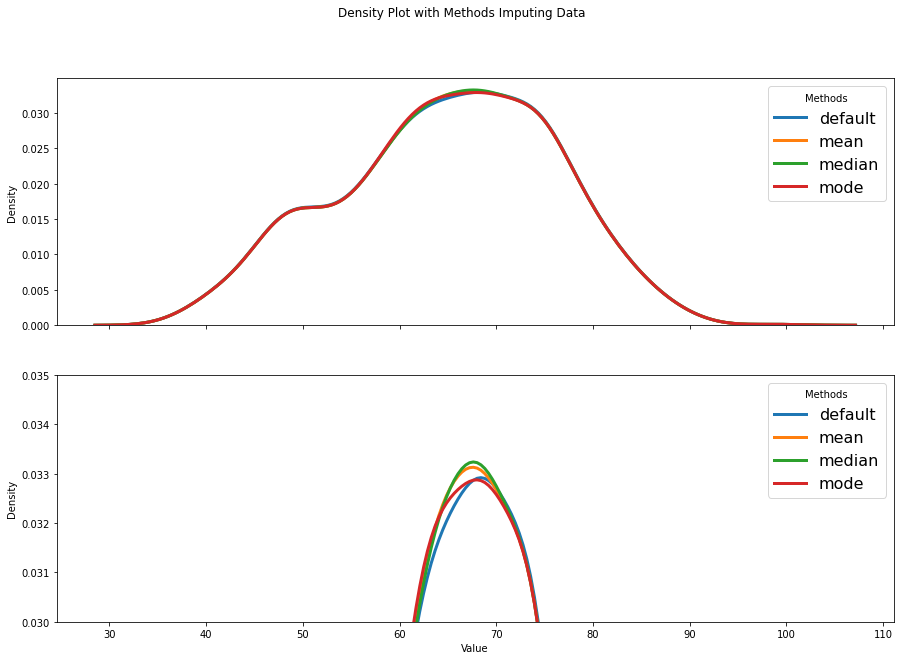

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


air_temp_9am['deviance'] = air_temp_9am['describe'].withColumn('mean', F.col('default')-F.col('mean')).\
                                                    withColumn('median', F.col('default')-F.col('median')).\
                                                    withColumn('mode', F.col('default')-F.col('mode'))

air_temp_9am['deviance'].show(truncate=False)

fig, axs = plt.subplots(2, sharex=True, sharey=False, figsize=(15, 10))

# sns.set(rc={'figure.figsize' : (15, 10)})

methods = ['mean', 'median', 'mode']

for ax in axs:
    sns.kdeplot(df.select(['air_temp_9am']).toPandas()['air_temp_9am'],
                linewidth=3, label='default', ax=ax)
    for method in methods:
        sns.kdeplot(air_temp_9am[method].toPandas()['air_temp_9am'],
                linewidth=3, label=method, ax=ax)
        
    ax.legend(prop={'size': 16}, title = 'Methods')
    
axs[1].set_ylim(0.030, 0.035)

plt.xlabel('Value')
plt.ylabel('Density')   
fig.suptitle('Density Plot with Methods Imputing Data')

plt.show()

Незначительное отличие среднего значения в методе замены средним значением объясняется ошибкой в вычислениях чисел с плавающей точкой.

Методы практически одинаково влияют на всю выборку данных, т.к. вставлялось *слишком малое* количество элементов и вставляемые значения зависили только от *самого столбца* (не анализировались значения других столбцов, как, например, в методе KNN).

Таким образом, можем выбрать метод, который будет выполняться быстрее всего: замена средним значением. А можем посчитать **усечённое среднее** и заменить пустые значения им:

In [ ]:
imputer = {}
for c in df.columns:
    quantiles_20th = df.approxQuantile(c, [0.2, 0.8], 0.1)
    imputer[c] = df.filter((quantiles_20th[0] <= F.col(c)) & (F.col(c) <= quantiles_20th[1])).\
                 select(F.mean(F.col(c))).first()[0]
    print(c, '=', imputer[c])
    
    # Заполнение средним значением
    # imputer[c] = df.select(F.mean(F.col(c))).first()[0] 

df = df.fillna(imputer)
df_descript = df.describe().toPandas().T
df_descript.rename(columns=dict(zip(df_descript.columns, df_descript.iloc[0])), inplace=True)
df_descript.drop(df_descript.index[0:2], inplace=True)
df_descript = df_descript.apply(pd.to_numeric)
df_descript

number = 474.0
air_pressure_9am = 918.3073218228056
air_temp_9am = 63.300605366286284
avg_wind_direction_9am = 130.1679325891029
avg_wind_speed_9am = 3.537799433735242
max_wind_direction_9am = 135.41216310174508
max_wind_speed_9am = 4.599078921243573
rain_accumulation_9am = 0.0
rain_duration_9am = 0.0
relative_humidity_9am = 22.445035838629718
relative_humidity_3pm = 26.152412754079148


,count,mean,stddev,min,max
air_pressure_9am,1095,918.880821,3.179964,907.990000,929.320000
air_temp_9am,1095,64.925421,11.150509,36.752000,98.906000
avg_wind_direction_9am,1095,142.182222,69.016965,15.500000,343.400000
avg_wind_speed_9am,1095,5.502780,4.547780,0.693451,23.554978
max_wind_direction_9am,1095,148.912790,67.150259,28.900000,312.200000
max_wind_speed_9am,1095,7.010407,5.589991,1.185578,29.840780
rain_accumulation_9am,1095,0.201966,1.589646,0.000000,24.020000
rain_duration_9am,1095,293.302277,1595.960236,0.000000,17704.000000
relative_humidity_9am,1095,34.241402,25.472067,6.090000,92.620000
relative_humidity_3pm,1095,35.344727,22.524079,5.300000,92.250000


Посчитаем корреляцию и построим диаграмму рассеяния для значений длительности дождя и количества осадков.

Корреляция = 0.7337968783310989


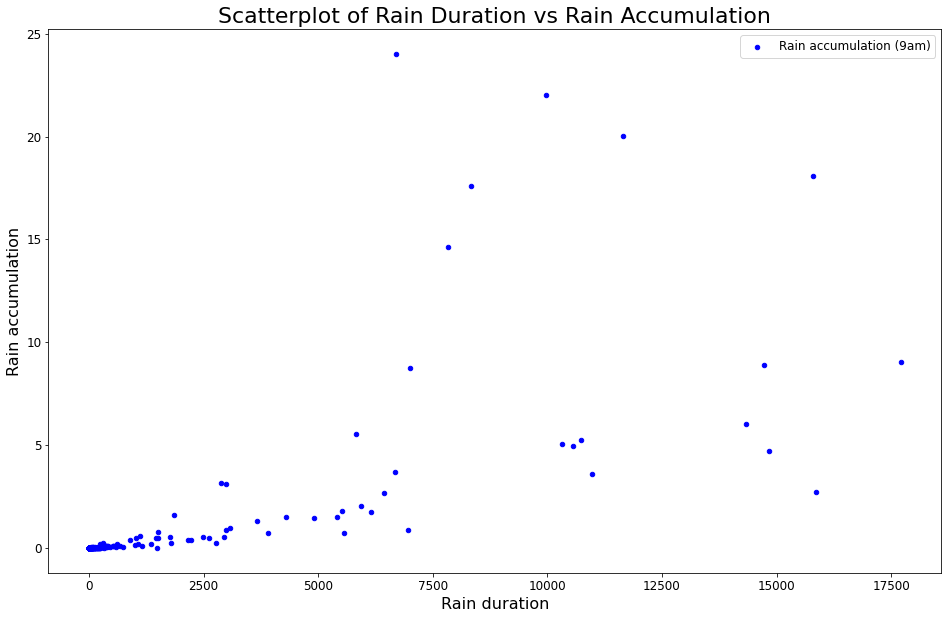

In [ ]:
print('Корреляция =', df.stat.corr('rain_duration_9am', 'rain_accumulation_9am'))

plt.figure(figsize=(16, 10))

plt.scatter('rain_duration_9am', 'rain_accumulation_9am', 
            data=df.toPandas(), s=20, c='blue', label='Rain accumulation (9am)')

# Если значений слишком много, то выбираем из них часть (sample) и только потом строим диаграмму
# plt.scatter('rain_duration_9am', 'rain_accumulation_9am', 
            # data=df.sample(0.1).toPandas(), s=20, c='blue', label='Rain accumulation (9am)')

plt.xlabel('Rain duration', fontsize=16)
plt.ylabel('Rain accumulation', fontsize=16)

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot of Rain Duration vs Rain Accumulation", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

Обработка **категориальных признаков** (https://drive.google.com/file/d/1SpFfqCufgElNtNFi-9YkRSkC70aTmUY4/view?usp=sharing):

In [ ]:
! unzip ieee-fraud-detection.zip
# ! head -5 train_transaction.csv 
train_df = spark.read.csv("train_transaction.csv",
               sep=',', header=True, inferSchema=True)

Archive:  ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   


Метод *label encoding*:

In [ ]:
from pyspark.ml.feature import StringIndexer

train_df.select('card4').show(10)
train_df_ind = train_df.fillna({'card4' : 'no'})
indexer = StringIndexer(inputCol="card4", outputCol="card4_index") 
train_df_ind_fit = indexer.fit(train_df_ind)
train_df_ind = train_df_ind_fit.transform(train_df_ind) 
train_df_ind.select(['card4', 'card4_index']).show(10)
train_df_ind.select(['card4', 'card4_index']).distinct().show()

+----------+
|     card4|
+----------+
|  discover|
|mastercard|
|      visa|
|mastercard|
|mastercard|
|      visa|
|      visa|
|      visa|
|      visa|
|mastercard|
+----------+
only showing top 10 rows

+----------+-----------+
|     card4|card4_index|
+----------+-----------+
|  discover|        3.0|
|mastercard|        1.0|
|      visa|        0.0|
|mastercard|        1.0|
|mastercard|        1.0|
|      visa|        0.0|
|      visa|        0.0|
|      visa|        0.0|
|      visa|        0.0|
|mastercard|        1.0|
+----------+-----------+
only showing top 10 rows

+----------------+-----------+
|           card4|card4_index|
+----------------+-----------+
|            visa|        0.0|
|      mastercard|        1.0|
|american express|        2.0|
|        discover|        3.0|
|              no|        4.0|
+----------------+-----------+



Метод *one-hot encoding*:

In [ ]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.functions import vector_to_array

encoder = OneHotEncoder(inputCols=['card4_index'], outputCols=['card4_onehot'],
                        dropLast=False)
train_df_onehot = encoder.fit(train_df_ind).transform(train_df_ind)
train_df_onehot.select(['card4', 'card4_index', 'card4_onehot']).distinct().show()
train_df_onehot = train_df_onehot.select(['card4', 'card4_index', 'card4_onehot', 
                        vector_to_array('card4_onehot').alias('card4_onehot_bincols')])
train_df_onehot.distinct().show(truncate=False)
                        
count_card_types = len(train_df_onehot.first()['card4_onehot'])

binary_cols = [(F.col('card4_onehot_bincols')[i].alias(f'{train_df_ind_fit.labels[i]}')) for i in range(count_card_types)]

train_df_onehot.select(['card4', 'card4_index', 'card4_onehot', 
                        *binary_cols]).\
                        distinct().show(truncate=False)

+----------------+-----------+-------------+
|           card4|card4_index| card4_onehot|
+----------------+-----------+-------------+
|      mastercard|        1.0|(5,[1],[1.0])|
|              no|        4.0|(5,[4],[1.0])|
|        discover|        3.0|(5,[3],[1.0])|
|            visa|        0.0|(5,[0],[1.0])|
|american express|        2.0|(5,[2],[1.0])|
+----------------+-----------+-------------+

+----------------+-----------+-------------+-------------------------+
|card4           |card4_index|card4_onehot |card4_onehot_bincols     |
+----------------+-----------+-------------+-------------------------+
|mastercard      |1.0        |(5,[1],[1.0])|[0.0, 1.0, 0.0, 0.0, 0.0]|
|american express|2.0        |(5,[2],[1.0])|[0.0, 0.0, 1.0, 0.0, 0.0]|
|discover        |3.0        |(5,[3],[1.0])|[0.0, 0.0, 0.0, 1.0, 0.0]|
|no              |4.0        |(5,[4],[1.0])|[0.0, 0.0, 0.0, 0.0, 1.0]|
|visa            |0.0        |(5,[0],[1.0])|[1.0, 0.0, 0.0, 0.0, 0.0]|
+----------------+--------

**Масштабирование переменных**:

In [ ]:
card5 = train_df.select('card5')
card5_describe = card5.describe()
mean_card5 = card5_describe.filter(F.col('summary') == 'mean').first()[1]
mean_card5 = float(mean_card5)
stddev_card5 = card5_describe.filter(F.col('summary') == 'stddev').first()[1]
stddev_card5 = float(stddev_card5)
min_card5 = card5_describe.filter(F.col('summary') == 'min').first()[1]
min_card5 = float(min_card5)
max_card5 = card5_describe.filter(F.col('summary') == 'max').first()[1]
max_card5 = float(max_card5)
print(f'{mean_card5=}\n{stddev_card5=}\n{min_card5=}\n{max_card5=}')
card5_describe.show()

mean_card5=199.27889697943476
stddev_card5=41.244452965022276
min_card5=100.0
max_card5=237.0
+-------+------------------+
|summary|             card5|
+-------+------------------+
|  count|            586281|
|   mean|199.27889697943476|
| stddev|41.244452965022276|
|    min|             100.0|
|    max|             237.0|
+-------+------------------+



Метод *z-нормализация*: *z = (x – μ) / σ*, где *x* - исходное значение, *μ* - среднее значение, *σ* - стандартное отклонение. Итоговые значения имеют среднее значение = 0, а стандартное отклонение = 1

In [ ]:
card5 = card5.withColumn('card5_z_score', (F.col('card5')-mean_card5)/stddev_card5)
card5.show()
card5.describe().show(truncate=False)

+-----+-------------------+
|card5|      card5_z_score|
+-----+-------------------+
|142.0|-1.3887660730525542|
|102.0|-2.3585934589054434|
|166.0|-0.8068696415408206|
|117.0|  -1.99490818921061|
|102.0|-2.3585934589054434|
|226.0| 0.6478714372385131|
|166.0|-0.8068696415408206|
|226.0| 0.6478714372385131|
|226.0| 0.6478714372385131|
|224.0| 0.5993800679458687|
|134.0| -1.582731550223132|
|224.0| 0.5993800679458687|
|226.0| 0.6478714372385131|
|226.0| 0.6478714372385131|
|226.0| 0.6478714372385131|
|226.0| 0.6478714372385131|
|226.0| 0.6478714372385131|
|219.0|0.47815164471425753|
|166.0|-0.8068696415408206|
|226.0| 0.6478714372385131|
+-----+-------------------+
only showing top 20 rows

+-------+------------------+-----------------------+
|summary|card5             |card5_z_score          |
+-------+------------------+-----------------------+
|count  |586281            |586281                 |
|mean   |199.27889697943476|-1.2609894180775036E-14|
|stddev |41.244452965022276|1.0000000

Метод *минимакс*: *x_new = (x_old - x_min) / (x_max - x_min)*. Итоговые значения находятся в диапазоне [0, 1]:

In [ ]:
card5 = card5.withColumn('card5_minmax_score', (F.col('card5')-min_card5)/(max_card5-min_card5))
card5.show()
card5.describe().show(truncate=False)

+-----+-------------------+--------------------+
|card5|      card5_z_score|  card5_minmax_score|
+-----+-------------------+--------------------+
|142.0|-1.3887660730525542| 0.30656934306569344|
|102.0|-2.3585934589054434|0.014598540145985401|
|166.0|-0.8068696415408206| 0.48175182481751827|
|117.0|  -1.99490818921061| 0.12408759124087591|
|102.0|-2.3585934589054434|0.014598540145985401|
|226.0| 0.6478714372385131|  0.9197080291970803|
|166.0|-0.8068696415408206| 0.48175182481751827|
|226.0| 0.6478714372385131|  0.9197080291970803|
|226.0| 0.6478714372385131|  0.9197080291970803|
|224.0| 0.5993800679458687|  0.9051094890510949|
|134.0| -1.582731550223132| 0.24817518248175183|
|224.0| 0.5993800679458687|  0.9051094890510949|
|226.0| 0.6478714372385131|  0.9197080291970803|
|226.0| 0.6478714372385131|  0.9197080291970803|
|226.0| 0.6478714372385131|  0.9197080291970803|
|226.0| 0.6478714372385131|  0.9197080291970803|
|226.0| 0.6478714372385131|  0.9197080291970803|
|219.0|0.47815164471